In [1]:
import sys
sys.path.append('../../')

import numpy as np

from src.mechanism.single_item import SingleItemAuction
from src.game import Game
from src.strategy import Strategy

from src.learner.frank_wolfe import FrankWolfe
from src.learner.poga import POGA
from src.learner.soda import SODA

from src.util.metrics import *

**Setting**
create specific Single Item Auction setting

In [107]:
# parameter mechanism
bidder = ['1']*2
o_space = {'1': [0.0, 1.0]}
a_space = {'1': [0.0, 1.0]}

param_prior = {
    'distribution':'uniform',
    'mu':0.5,
    'sigma':0.15,
    }
param_util = {
    'payment_rule': 'first_price', 
    'tie_breaking': 'lose', 
    'utility_type': 'ROI',
    'budget': 1.01,
    }

# parameter approximation game
n = 64
m = 64

# create mechanism
mechanism = SingleItemAuction(bidder, o_space, a_space, param_prior, param_util)

# create approximation game
game = Game(mechanism, n, m)
if not mechanism.own_gradient:
    game.get_utility(mechanism)



own gradient


**Learner**
Specify Learning Algorithm

In [108]:
# parameter learner
max_iter = int(1e4)
tol = 1e-5
stop_criterion = 'dist_euclidean'
steprule_bool = True
eta = 10
beta = 1/20

#learner = SODA(max_iter, tol, stop_criterion, steprule_bool, eta, beta)
learner = FrankWolfe(max_iter, tol, stop_criterion)
#learner = POGA(max_iter, tol, stop_criterion, steprule_bool, eta, beta)

Run Learning Algorithm

In [109]:
#create and initialize strategies
strategies = {}
for i in game.set_bidder:
    strategies[i] = Strategy(i, game)
    strategies[i].initialize('random')
    #strategies[i].initialize('matrix', {"init_matrix": bne})
    
# run soda
learner.run(mechanism, game, strategies, disable_tqdm=False, print=True)

 51%|██████████▏         | 5.10k/10.0k [00:01<00:01, 3.51kit/s]

Convergence after 5101 iterations
Value of stopping criterion (dist_euclidean) 1e-05


Visualization of the learning process and the final result

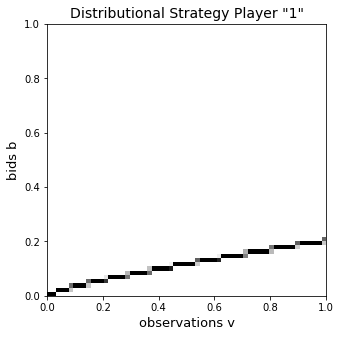

In [110]:
strategies['1'].plot(more=False)

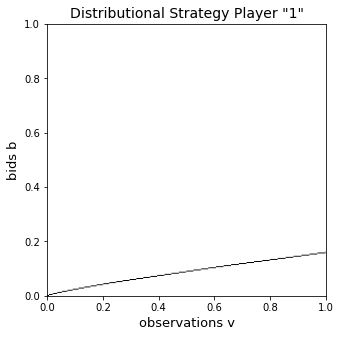

In [106]:
strategies['1'].plot(more=False)

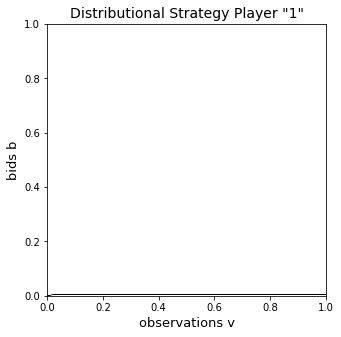

In [62]:
strategies['1'].plot(more=False)

In [63]:
import matplotlib.pyplot as plt

In [124]:
x = np.linspace(0, 1, 100)
def f(x, val=0.5):
    return val/x + np.log(1.01-x)

In [127]:
def f(x, N=3):
    return x*(N-1)*(1-x)/(1+(N-1)*x)

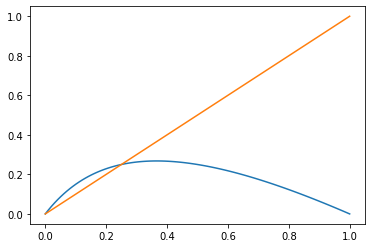

In [128]:
plt.plot(x,f(x))
plt.plot(x,x)